In [9]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import re
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from utils import helpers as hpr

### Load all changes

In [34]:
df = hpr.combine_openstack_data(changes_path="/Changes3/")
df = df[df['status']!='NEW']

Reading OpenStack changes...
OpenStack changes loaded successfully...


In [22]:
result = []
for label in ['Test']:
    for i in range(10):
        df_path = f"Files/Data/{label}/{i}.csv"
        train = pd.read_csv(df_path)
        # train['is_cross'].value_counts()
        train = pd.merge(
            train,
            df[["number", "owner_account_id"]],
            left_on="Source",
            right_on="number",
            suffixes=["_target", "_source"],
            how="left"
        )
        train = pd.merge(
            train,
            df[["number", "owner_account_id"]],
            left_on="Target",
            right_on="number",
            suffixes=["_source", "_target"],
            how="left"
        )
        train.rename(columns={
            "owner_account_id_source": "Source_dev",
            "owner_account_id_target": "Target_dev"
        }, inplace=True)
        train.drop(columns=['number_source', 'number_target'], inplace=True)
        # for c in train.columns:
        #     if train[c].isna().sum() > 0:
        #         result.append(c)
        train.to_csv(df_path, index=None)

In [17]:
df_test = pd.read_csv("./Files/Data/Test/7.csv")
df.loc[df['number'].isin(df_test['Source'].unique()), 'status'].value_counts()

status
MERGED       3865
ABANDONED     655
Name: count, dtype: int64

In [57]:
# Add additional metadata through merges
# df2 = pd.merge(
#     left=df2,
#     right=df[["number", "is_owner_bot", "status"]],
#     left_on=['Source'],
#     right_on=['number'],
#     how='left',
#     suffixes=('_target', '_source')
# )

# df2 = pd.merge(
#     left=df2,
#     right=df[["number", "is_owner_bot", "status"]],
#     left_on=['Target'],
#     right_on=['number'],
#     how='left',
#     suffixes=('_source', '_target')
# )
df3.drop(columns=["number_source", "number_target"], inplace=True)
df3 = pd.merge(
    left=df3,
    right=df[["number", "is_owner_bot"]],
    left_on=['Source'],
    right_on=['number'],
    how='left',
    suffixes=('_target', '_source')
)

df3 = pd.merge(
    left=df3,
    right=df[["number", "is_owner_bot"]],
    left_on=['Target'],
    right_on=['number'],
    how='left',
    suffixes=('_source', '_target')
)

In [34]:
df2 = df2[(df2["is_owner_bot_source"]==0)&(df2["is_owner_bot_target"]==0)]

In [38]:
df2 = df2[(df2["status_source"]!="NEW")&(df2["status_source"]!="NEW")]

In [48]:
len(set(hpr.flatten_list(df2[['Source', 'Target']].values)))

49181

In [64]:
df2 = df2[df2["Source"]!=df2["Target"]]

In [60]:
df3 = df3[(df3["is_owner_bot_source"]==0)&(df3["is_owner_bot_target"]==0)]
df3 = df3[(df3["Source_status"]!="NEW")&(df3["Target_status"]!="NEW")]
len(set(hpr.flatten_list(df3[['Source', 'Target']].values)))

48854

In [ ]:
df['messages'] = df.loc[df['messages'].notna(), 'messages'].map(ast.literal_eval)

In [36]:
df['Year'] = df['created'].map(lambda x: x.year)

### The median of changes per day

In [37]:
# Convert 'creation_date' to string format 'year-month-day'
df['created_str'] = df['created'].dt.strftime('%Y-%m-%d')

# Group by 'creation_date' and count the number of rows per day
daily_counts = df.groupby(df['created'].dt.date).size()

# Display the result
daily_counts_df = daily_counts.reset_index(name='count')
daily_counts_df.columns = ['created_str', 'count']

daily_counts_df['count'].median()

136.0

In [410]:
df_build_fialure = pd.read_csv(osp.join(".", "Files", "Metrics", "num_build_failures.csv"))

### The growth of dependent changes

In [53]:
df_dep_ned_cha = pd.read_csv(osp.join('Files', 'source_target_evolution.csv'))
deps_need_changes = df_dep_ned_cha['Source'].tolist() + df_dep_ned_cha['Target'].tolist()
df['Count'] = 0
df_reduced = df.loc[df['number'].isin(deps_need_changes), ['status', 'created', 'Count']]

df_reduced['Year'] = df_reduced['created'].map(lambda x: x.year)

# df_reduced = df_reduced.groupby('Year').count().reset_index(level=0)

In [54]:
df_reduced

,status,created,Count,Year
604,MERGED,2013-04-03 15:23:05,0,2013
605,ABANDONED,2013-04-03 15:23:50,0,2013
31965,MERGED,2014-01-03 13:58:35,0,2014
33031,ABANDONED,2014-01-12 00:41:12,0,2014
33287,MERGED,2014-01-13 22:48:28,0,2014
...,...,...,...,...
711925,MERGED,2024-06-06 12:00:46,0,2024
711926,MERGED,2024-06-06 12:09:55,0,2024
711951,MERGED,2024-06-07 10:55:55,0,2024
711955,MERGED,2024-06-07 12:57:25,0,2024


In [55]:
df_merged = df_reduced[df_reduced['status']=='MERGED']
df_merged = df_merged.groupby('Year').count().reset_index(level=0)
df_merged['Status'] = 'MERGED'

df_abandoned = df_reduced[df_reduced['status']=='ABANDONED']
df_abandoned = df_abandoned.groupby('Year').count().reset_index(level=0)
df_abandoned['Status'] = 'ABANDONED'

df_new = df_reduced[df_reduced['status']=='NEW']
df_new = df_new.groupby('Year').count().reset_index(level=0)
df_new['Status'] = 'NEW'

In [56]:
df_reduced = pd.concat((df_merged[['Year', 'Status', 'Count']], df_abandoned[['Year', 'Status', 'Count']], df_new[['Year', 'Status', 'Count']]))

In [57]:
def calc_perc_dependencies(row):
    all_changes = df.loc[(df['status']==row['Status'])&(df['Year'] == row['Year']), 'number'].nunique()
    return round(100 * (row['Count'] / all_changes), 2)

In [58]:
df_reduced['percentage'] = df_reduced.apply(calc_perc_dependencies, axis=1)

In [61]:
df_reduced[df_reduced['Status']=='MERGED'].to_csv("./Files/Preliminary/deps_evolution2.csv", index=None)

### When dependent changes are identified

In [13]:
def time_diff(start, end):
    if start > end:
        start, end = end, start
    current_date =  datetime.strptime(end, "%Y-%m-%d %H:%M:%S") 
    previous_date = datetime.strptime(start, "%Y-%m-%d %H:%M:%S") 
    diff = current_date - previous_date
    diff = float("{:.2f}".format(diff.total_seconds() / 3600))
    return diff


def extract_attr(x, attr):
    '''Extracts the passed-on parameter values out of the commit message 
    '''
    rs = re.findall("%s:\s[a-zA-Z0-9/\.\:\+\-\#]{6,}" % (attr), x)
    result = []
    for row in rs:
        row = row[len(attr) + 2:]
        change_id_pattern = re.search(r"[a-zA-Z0-9]{41}", row)
        if change_id_pattern:
            result.append(change_id_pattern[0])
            continue
        number_pattern = re.search("#?https?[\:][/]{2}review[\.](opendev|openstack)[\.]org([a-z0-9A-Z\-\+/\.#]*)\d+", row)
        if number_pattern:
            result.append(int(re.search("\d+$", number_pattern[0][0:])[0]))
    return result if len(result) != 0 else None


def retrieve_revision_date(row, attr, return_revision_date=True):
    number = None
    second_number = None

    if attr == "Depends-On":
        number = row["Target"]
        second_number = row["Source"]
        change_id = row["Source_change_id"]
    else:
        number = row["Source"]
        second_number = row["Target"]
        change_id = row["Target_change_id"]

    df_row = df.loc[df["number"] == number]
    revisions = ast.literal_eval(df_row["revisions"].values[0])
    revisions = sorted(revisions, key=lambda x: x["created"])
    if  len(revisions) == 1:
        if return_revision_date:
            return revisions[0]["created"][:-11]
        else:
            return 1

    first_revision = revisions[0]
    first_message = first_revision["message"]

    results = extract_attr(first_message, attr)

    if results and ((change_id in results) or (second_number in results)):
        if return_revision_date:
            return first_revision["created"][:-11]
        else:
            return 1

    for i in range(1,len(revisions)):
        current_message = revisions[i]["message"]
        created = revisions[i]["created"]
        results = extract_attr(current_message, attr)
        
        if results and ((change_id in results) or (second_number in results)):

            if return_revision_date:
                return created[:-11]
            else:
                return i + 1

def is_same_developer(row):
    return "Same" if row["Source_dev"] == row["Target_dev"] else "Different"

def identify_dependency(row):
    source_date = row["Source_date"] 
    target_date = row["Target_date"]
    link_date = datetime.strptime(row["link_date"], "%Y-%m-%d %H:%M:%S")
    delta1 = (target_date - link_date).total_seconds() / (60 * 60)
    delta2 = (source_date - link_date).total_seconds() / (60 * 60)

    return abs(delta2)
    # return min(abs(delta1), abs(delta2))

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\:'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\:'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/var/folders/p4/wn9d12jj6g78td0tl7gx7xlw0000gp/T/ipykernel_1293/1224035538.py:14: SyntaxWarning: invalid escape sequence '\s'
  rs = re.findall("%s:\s[a-zA-Z0-9/\.\:\+\-\#]{6,}" % (attr), x)
/var/folders/p4/wn9d12jj6g78td0tl7gx7xlw0000gp/T/ipykernel_1293/1224035538.py:22: SyntaxWarning: invalid escape sequence '\:'
  number_pattern = re.search("#?https?[\:][/]{2}review[\.](opendev|openstack)[\.]org([a-z0-9A-Z\-\+/\.#]*)\d+", row)
/var/folders/p4/wn9d12jj6g78td0tl7gx7xlw0000gp/T/ipykernel_1293/1224035538.py:24: SyntaxWarning: invalid escape sequence '\d'
  result.append(int(re.search("\d+$", number_pattern[0][0:])[0]))


#### Depends-On

In [16]:
all_changes = df['number'].unique()

In [ ]:
# # Read the CSV file
df_depends_on = pd.read_csv("./Files/source_target_depends2.csv")

# # # Filter rows where both Source and Target are in all_changes
df_depends_on = df_depends_on[df_depends_on['Source'].isin(all_changes) & df_depends_on['Target'].isin(all_changes)]

# # # Get Source fields using merge
df_depends_on = pd.merge(
    df_depends_on,
    df[["number", "status", "change_id", "is_owner_bot", "owner_account_id", "created"]].rename(
        columns={
            "number": "Source",
            "status": "Source_status",
            "change_id": "Source_change_id",
            "is_owner_bot": "is_source_bot",
            "owner_account_id": "Source_dev",
            "created": "Source_date"
        }
    ),
    on="Source",
    how="left"
)

# Get Target fields using merge
df_depends_on = pd.merge(
    df_depends_on,
    df[["number", "status", "change_id", "revisions", "is_owner_bot", "owner_account_id", "created"]].rename(
        columns={
            "number": "Target",
            "status": "Target_status",
            "change_id": "Target_change_id",
            "is_owner_bot": "is_target_bot",
            "owner_account_id": "Target_dev",
            "created": "Target_date"
        }
    ),
    on="Target",
    how="left"
)

# Add is_cross column
df_depends_on["is_cross"] = df_depends_on.apply(lambda row: "Cross" if row["Source_repo"] != row["Target_repo"] else "Same", axis=1)

df_depends_on["link_date"] = df_depends_on.apply(retrieve_revision_date, args=("Depends-On",), axis=1)
df_depends_on["worked_revisions"] = df_depends_on.apply(retrieve_revision_date, args=("Depends-On",False,), axis=1)
df_depends_on["same_dev"] = df_depends_on.apply(is_same_developer, axis=1)
df_depends_on["when_identified"] = df_depends_on[["Source_date", "Target_date", "link_date"]].apply(identify_dependency, axis=1)
df_depends_on["deps_label"] = "Depends-On"

# df_depends_on = df_depends_on[(df_depends_on['Source_status']=='MERGED')|(df_depends_on['Target_status']=='MERGED')]


In [22]:
df_depends_on

,Source,Target,Source_repo,Target_repo,Source_status,Source_change_id,is_source_bot,Source_dev,Source_date,Target_status,Target_change_id,revisions,is_target_bot,Target_dev,Target_date,is_cross
0,26005,26006,oslo-incubator,ceilometer,MERGED,Ic01e0f16fe9e7634708fbb51499ccea3f4f40d63,0,2,2013-04-03 15:23:05,ABANDONED,I2a3be7741e48b3b9fa5b0f182ddb25a0e46977ce,"[{'number': 1, 'created': '2013-04-03 15:23:50...",0,2,2013-04-03 15:23:50,Cross
1,66146,64831,pbr,requirements,ABANDONED,I01b2b7c78e7e7144280c98cdbbe29b012a8a8d93,0,2750,2014-01-12 00:41:12,MERGED,I7a22dbb47e85f3adf5d43583f5b9bac4f65fde14,"[{'number': 2, 'created': '2014-01-12 00:45:40...",0,2750,2014-01-03 13:58:35,Cross
2,66453,71359,neutron,devstack,MERGED,I92619a95bca2ae0c37e7fdd39da30119b43d1ad6,0,1923,2014-01-13 22:48:28,MERGED,I0958457355036fdab93156cd7fb4afd1a458918b,"[{'number': 6, 'created': '2014-03-03 14:50:04...",0,1923,2014-02-05 19:48:53,Cross
3,153227,83150,project-config,oslo.messaging,ABANDONED,I893f9a1c259157bc6e6829fe34067ede365c15b7,0,8415,2015-02-05 13:29:18,ABANDONED,I9708322308655cbb4832fec1351ea1215e6e11ef,"[{'number': 4, 'created': '2015-02-05 16:02:27...",0,6928,2014-03-26 18:01:12,Cross
4,178352,86978,project-config,grenade,MERGED,I3e0f01221590f5e42f0c8fa659df62f83e0591af,0,6899,2015-04-28 19:24:44,ABANDONED,Id8f5875e1ae6a813808807571f511939ab4caf88,"[{'number': 24, 'created': '2015-05-04 13:57:3...",0,4328,2014-04-11 17:54:33,Cross
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37036,920758,920759,openstack-ansible,openstack-ansible-openstack_hosts,MERGED,I20efb9be544db6d4d66c9b8d968aaf44d96d899f,0,25023,2024-05-29 15:42:49,MERGED,I1c2e1d10efe0e9f7a8f4c5f0d914825767a2f655,"[{'number': 5, 'created': '2024-05-29 16:50:26...",0,25023,2024-05-29 15:45:42,Cross
37037,920979,920978,neutron-tempest-plugin,neutron,MERGED,I3cae6a14044010ee16f328036278a0542a03a701,0,13861,2024-06-03 06:56:01,ABANDONED,Idd36a280692b594c89bfb16e86adb9ea72522dee,"[{'number': 4, 'created': '2024-06-03 06:57:40...",0,13861,2024-06-03 06:41:12,Cross
37038,921306,921311,neutron,neutron,ABANDONED,Ie77b9b77be877b78e2b18a40a2fbc4e3bed57595,0,9656,2024-06-04 16:17:23,ABANDONED,I0c1845109ececb22b9e9ae145d5ed01967867412,"[{'number': 2, 'created': '2024-06-04 16:35:53...",0,9656,2024-06-04 16:33:24,Same
37039,921443,921444,openstack-ansible-plugins,openstack-ansible-os_heat,MERGED,I2ebf91cd48f97ad063fa0a4552e948db6728481c,0,28619,2024-06-06 12:00:46,MERGED,Ia575f0528b5e7eb10ae79aa121c063b221fc744e,"[{'number': 1, 'created': '2024-06-06 12:09:55...",0,28619,2024-06-06 12:09:55,Cross


#### Needed-By

In [ ]:
# Read the CSV file
df_needed_by = pd.read_csv("./Files/source_target_needed2.csv")

# Filter rows where both Source and Target are in all_changes
df_needed_by = df_needed_by[df_needed_by['Source'].isin(all_changes) & df_needed_by['Target'].isin(all_changes)]

# Get Source fields using merge
df_needed_by = pd.merge(
    df_needed_by,
    df[["number", "status", "change_id", "is_owner_bot", "owner_account_id", "created"]].rename(
        columns={
            "number": "Source",
            "status": "Source_status",
            "change_id": "Source_change_id",
            "is_owner_bot": "is_source_bot",
            "owner_account_id": "Source_dev",
            "created": "Source_date"
        }
    ),
    on="Source",
    how="left"
)

# Get Target fields using merge
df_needed_by = pd.merge(
    df_needed_by,
    df[["number", "status", "change_id", "revisions", "is_owner_bot", "owner_account_id", "created"]].rename(
        columns={
            "number": "Target",
            "status": "Target_status",
            "change_id": "Target_change_id",
            "is_owner_bot": "is_target_bot",
            "owner_account_id": "Target_dev",
            "created": "Target_date"
        }
    ),
    on="Target",
    how="left"
)

# Add is_cross column
df_needed_by["is_cross"] = df_needed_by.apply(lambda row: "Cross" if row["Source_repo"] != row["Target_repo"] else "Same", axis=1)

df_needed_by["link_date"] = df_needed_by.apply(retrieve_revision_date, args=("Depends-On",), axis=1)
df_needed_by["worked_revisions"] = df_needed_by.apply(retrieve_revision_date, args=("Depends-On",False,), axis=1)
df_needed_by["same_dev"] = df_needed_by.apply(is_same_developer, axis=1)
df_needed_by["when_identified"] = df_needed_by[["Source_date", "Target_date", "link_date"]].apply(identify_dependency, axis=1)
df_needed_by["deps_label"] = "Needed-By"

# df_needed_by = df_needed_by[(df_needed_by['Source_status']=='MERGED')|(df_needed_by['Target_status']=='MERGED')]

In [ ]:
dependency_identification = pd.concat((df_depends_on, df_needed_by)).sort_values("when_identified")
dependency_identification = dependency_identification.drop_duplicates(subset=["Source", "Target"], keep="first")

### The frequency of changes that depends among each other

In [41]:
df_deps = pd.read_csv("./Files/source_target_evolution.csv")

In [42]:
# len(set(df_deps["Source"].tolist()).union(df_deps["Target"].tolist()))
# df_deps = df_deps[(df_deps['Source_status']!='NEW')&(df_deps['Target_status']!='NEW')]
df_deps.drop(columns=["number_source", "number_target"], inplace=True)
df_deps = pd.merge(
    left=df_deps,
    right=df[["number", "change_id"]],
    left_on=['Source'],
    right_on=['number'],
    how='left',
    suffixes=('_target', '_source')
)
df_deps = pd.merge(
    left=df_deps,
    right=df[["number", "change_id"]],
    left_on=['Target'],
    right_on=['number'],
    how='left',
    suffixes=('_source', '_target')
)

In [37]:
df_deps = df_deps[(df_deps['Source_status']=="MERGED")|(df_deps['Target_status']=="MERGED")]

In [43]:
df_deps.drop_duplicates(subset=["change_id_source", "change_id_target"], inplace=True)

In [44]:
df_deps

,Source,Target,Source_repo,Target_repo,Source_status,owner_account_id_source,Source_created,Target_status,owner_account_id_target,Target_created,number_source,change_id_source,number_target,change_id_target
0,26005,26006,oslo-incubator,ceilometer,MERGED,2,2013-04-03 15:23:05,ABANDONED,2,2013-04-03 15:23:50,26005.0,Ic01e0f16fe9e7634708fbb51499ccea3f4f40d63,26006.0,I2a3be7741e48b3b9fa5b0f182ddb25a0e46977ce
1,66146,64831,pbr,requirements,ABANDONED,2750,2014-01-12 00:41:12,MERGED,2750,2014-01-03 13:58:35,66146.0,I01b2b7c78e7e7144280c98cdbbe29b012a8a8d93,64831.0,I7a22dbb47e85f3adf5d43583f5b9bac4f65fde14
2,66453,71359,neutron,devstack,MERGED,1923,2014-01-13 22:48:28,MERGED,1923,2014-02-05 19:48:53,66453.0,I92619a95bca2ae0c37e7fdd39da30119b43d1ad6,71359.0,I0958457355036fdab93156cd7fb4afd1a458918b
3,153227,83150,project-config,oslo.messaging,ABANDONED,8415,2015-02-05 13:29:18,ABANDONED,6928,2014-03-26 18:01:12,153227.0,I893f9a1c259157bc6e6829fe34067ede365c15b7,83150.0,I9708322308655cbb4832fec1351ea1215e6e11ef
4,178352,86978,project-config,grenade,MERGED,6899,2015-04-28 19:24:44,ABANDONED,4328,2014-04-11 17:54:33,178352.0,I3e0f01221590f5e42f0c8fa659df62f83e0591af,86978.0,Id8f5875e1ae6a813808807571f511939ab4caf88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63225,903099,903095,requirements,cinder,MERGED,13425,2023-12-07 18:02:36,MERGED,13425,2023-12-07 16:47:22,903099.0,I9027eac8bd5bf1efc9ef619d578b2e0d9450027f,903095.0,I3deae1cc6bbe5ef5820224f72bb02565677e1ade
63226,905571,901480,vitrage,vitrage-tempest-plugin,MERGED,28619,2024-01-15 09:22:15,MERGED,28619,2023-11-20 18:56:15,905571.0,Ib49b025e75acddfbbdca4c5fd885f0dc615c4185,901480.0,Icdbe494f398420faa36cfcca3e50233b805ad45d
63227,913611,714728,charms.openstack,openstack-zuul-jobs,MERGED,10058,2024-03-19 01:23:42,MERGED,8556,2020-03-24 17:42:28,913611.0,Ib854bb24f9bba1cca8f6d4e201166d93ba4850af,714728.0,Ic17ec65b2229d46b799e0c41824e6e368723098b
63228,913612,714728,charms.openstack,openstack-zuul-jobs,MERGED,10058,2024-03-19 01:28:23,MERGED,8556,2020-03-24 17:42:28,913612.0,If1df5780a1e92e7d5b1c17b792ea74dcae2d15d0,714728.0,Ic17ec65b2229d46b799e0c41824e6e368723098b


In [13]:
df_deps = pd.read_csv("./Files/source_target_evolution.csv")
# df_deps = pd.merge(
#     left=df_deps,
#     right=df[["number", "owner_account_id", "created"]],
#     left_on=['Source'],
#     right_on=['number'],
#     how='left',
#     suffixes=('_target', '_source')
# )
# df_deps = pd.merge(
#     left=df_deps,
#     right=df[["number", "owner_account_id", "created"]],
#     left_on=['Target'],
#     right_on=['number'],
#     how='left',
#     suffixes=('_source', '_target')
# )
# df_deps.rename(columns={
#     "status_source": "Source_status",
#     "status_target": "Target_status",
#     "author_source": "Source_author",
#     "status_author": "Target_status",
#     "created_source": "Source_created",
#     "created_target": "Target_created"}, inplace=True)
df_deps.dropna(subset=["Source_status", "Target_status"], inplace=True)
# df_deps.drop(columns=["number_source", "number_target"], inplace=True)
# df_deps.to_csv("./Files/source_target_evolution.csv", index=None)

# 1. Number of dependencies a Target has (i.e., how many sources depend on this target)
target_dependency_count = df_deps.groupby(
    'Target')['Source'].nunique().reset_index()
target_dependency_count.columns = ['Change', 'Num_Sources']

# 2. Number of changes a Source is depended upon in Target (i.e., how many targets depend on this source)
source_dependency_count = df_deps.groupby(
    'Source')['Target'].nunique().reset_index()
source_dependency_count.columns = ['Change', 'Num_Targets']

# Combine both metrics into a single DataFrame
dependency_summary = pd.merge(
    target_dependency_count, source_dependency_count, on='Change', how='outer').fillna(0)
dependency_summary[['Num_Sources', 'Num_Targets']] = dependency_summary[[
    'Num_Sources', 'Num_Targets']].astype(int)

In [14]:
dependency_summary.loc[dependency_summary["Num_Sources"]>0, ["Num_Sources"]].max()

Num_Sources    76
dtype: int64

### Calculating the lag

In [ ]:
def time_diff(row):
    start, end = row['Source_date'], row['Target_date']
    if start > end:
        start, end = end, start
    # current_date =  datetime.strptime(end, "%Y-%m-%d %H:%M:%S") 
    # previous_date = datetime.strptime(start, "%Y-%m-%d %H:%M:%S") 
    diff = end - start
    diff = float("{:.2f}".format(diff.total_seconds() / 3600))
    return diff

def lag_nbr_changes(row):
    start, end = row['Source_date'], row['Target_date']
    if start > end:
        start, end = end, start
    # end =  datetime.strptime(end, "%Y-%m-%d %H:%M:%S") 
    # start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S") 
    res = df.loc[(df['created']>=start)&(df['created']<=end), "number"].nunique()
    return res

In [ ]:
dependency_identification['Source_date'] = pd.to_datetime(dependency_identification['Source_date'])
dependency_identification['Target_date'] = pd.to_datetime(dependency_identification['Target_date'])

In [ ]:
dependency_identification['lag'] = dependency_identification.apply(time_diff, axis=1)
# dependency_identification['lag'] = dependency_identification.apply(time_diff, axis=1)

In [ ]:
df_lag = dependency_identification[['lag']]

# Calculate Z-scores
z_scores = np.abs((df_lag - df_lag.mean()) / df_lag.std())

# Set a threshold for identifying outliers
threshold = 3

# Filter out the outliers
dependency_identification = dependency_identification[(z_scores < threshold).all(axis=1)]

In [164]:
len(dependency_identification.loc[dependency_identification['lag']<=38*24, "lag"])/len(dependency_identification)

0.8570106554559637

In [165]:
dependency_identification['lag'].max()

6766.86

In [174]:
len(dependency_identification)
# len(dependency_identification[(dependency_identification['Source_status']!="NEW") & (dependency_identification['Target']!="NEW")])

37821

In [173]:
len(set(hpr.flatten_list(dependency_identification[['Source', 'Target']].values)))

49357

In [ ]:
dependency_identification['deps_label'].value_counts()

In [ ]:
dependency_identification['lag_changes'] = dependency_identification.apply(lag_nbr_changes, axis=1)

In [ ]:
dependency_identification.loc[dependency_identification['lag']==57, 'lag_changes']

In [185]:
dependency_identification.to_csv("./Files/source_target_evolution_clean.csv", index=None)

### The lag of paired changed that were made by the same vs. different developers

In [1]:
import pandas as pd

In [2]:
df_deps = pd.read_csv("./Files/source_target_evolution_clean.csv")
df_deps["lag"] /= 24
df_deps.loc[(df_deps["same_dev"]!="Same"), "lag"].median()

10.040625

In [31]:
len(df_deps[(df_deps["same_dev"]=="Same")&(df_deps["lag"]>=5)])/len(df_deps[df_deps["same_dev"]=="Same"])

0.32740799027146894

In [4]:
6766.86/24

281.9525

In [7]:
len(df_deps[df_deps['Source_dev']!=df_deps["Target_dev"]])

9862

In [26]:
sample1 = df_deps.loc[df_deps['Source_dev']!=df_deps["Target_dev"], "lag"].tolist()
sample2 = df_deps.loc[df_deps['Source_dev']==df_deps["Target_dev"], "lag"].tolist()
_, p_value = mannwhitneyu(sample1, sample2, method='asymptotic')
if p_value < 0.05:
    print(f"Mann-Whitney U rank test: statistically significant")
else:
    print(f"Mann-Whitney U rank test: no statistical significance")

print(f"Cliff's Delta: {cliffs_delta(sample1, sample2)}")

Mann-Whitney U rank test: statistically significant
Cliff's Delta: (0.4491383539281514, 'medium')


In [21]:
np.median(sample2)/24

0.8791666666666668

### When miss a dependency

In [99]:
after_revi_deps = df_depends_on.loc[df_depends_on['when_identified']>1, 'Source'].unique()
after_revi_need = df_needed_by.loc[(~df_needed_by['Target'].isin(after_revi_deps))&(df_needed_by['when_identified']>1), 'Target'].unique()
after_review = set(after_revi_deps.tolist()+after_revi_deps.tolist())

all_deps_deps_on = df_depends_on['Source'].unique()
all_deps_need = df_needed_by.loc[(~df_needed_by['Target'].isin(all_deps_deps_on)), 'Target'].unique()
all_dependent_changes = set(all_deps_deps_on.tolist()+all_deps_need.tolist())

In [101]:
df_depends_ident = df_depends_on.loc[(df_depends_on['Source'].isin(after_revi_deps)), "when_identified"].tolist()
df_needed_ident = df_needed_by.loc[(df_needed_by['Target'].isin(after_revi_need)), "when_identified"].tolist()
ident_time = df_depends_ident + df_needed_ident

In [181]:
np.max(ident_time)

61672.0075

In [103]:
df_depends_ident = df_depends_on.loc[(df_depends_on['worked_revisions']>1)&(df_depends_on['when_identified']>0)&(df_depends_on['Source'].isin(after_revi_deps)), "when_identified"].tolist()
df_needed_ident = df_needed_by.loc[(df_needed_by['worked_revisions']>1)&(df_needed_by['when_identified']>0)&(df_needed_by['Target'].isin(after_revi_need)), "when_identified"].tolist()
after_rev_ident_time = df_depends_ident + df_needed_ident

In [398]:
pd.DataFrame({"time": after_rev_ident_time}).to_csv(osp.join(".", "Files","Preliminary", "deps_ident.csv"), index=None)

In [182]:
all_dependent_changes = pd.concat((df_depends_on, df_needed_by))
all_dependent_changes.drop_duplicates(subset=['Source', 'Target'], inplace=True)
all_dependent_changes = set(hpr.flatten_list(all_dependent_changes[['Source', 'Target']].values))

In [183]:
len(df[(df['status']=='MERGED')&df['number'].isin(after_review)])/len(df[df['number'].isin(all_dependent_changes)&(df['status']=='MERGED')])

0.45307284254107905

In [184]:
dependency_identification.loc[(dependency_identification['worked_revisions']>1)&(dependency_identification['worked_revisions']>1), "when_identified"].max()

nan

In [137]:
dependency_identification.to_csv(osp.join(".", "Files", "Preliminary", "deps_ident.csv"), index=False)

In [109]:
dependency_identification = pd.read_csv(osp.join(".", "Files", "Preliminary", "deps_ident.csv"))

In [110]:
dependency_identification.loc[dependency_identification['iden_type']=='slow', 'when_identified'].median()/24

91.7265162037037

In [32]:
# dependency_identification['when_identified'].median()
dependency_identification.loc[(dependency_identification['Source_status']=='MERGED')&(dependency_identification['Target_status']=='MERGED')].to_csv(osp.join(".", "Files", "Preliminary", "deps_ident.csv"), index=False)

### How many dependent changes contain a build failure

In [411]:
df_dependent_cha = pd.DataFrame({'number': list(all_dependent_changes)})
df_dependent_cha = pd.merge(
    df_dependent_cha,
    right=df_build_fialure,
    on='number'
)

In [413]:
len(df_dependent_cha[(df_dependent_cha['num_build_failures']>1)&df_dependent_cha['number'].isin(after_review)])/len(df_dependent_cha[(df_dependent_cha['num_build_failures']>1)])

0.5158020274299344

In [404]:
def has_build_failure(nbr):
    res = df.loc[df['number']==nbr, 'messages'].tolist()[0]
    # print(res)
    return type(res) == list

def when_deps_linked(row):
    link_date_deps = df_depends_on.loc[df_depends_on['Target']==row['number'], 'link_date'].tolist()
    link_date_need = df_needed_by.loc[df_needed_by['Source']==row['number'], 'link_date'].tolist()
    res = link_date_deps + link_date_need
    res.sort()
        
    return res if len(res) > 0 else None

def when_build_failure_occur(row):
    linked_date = row['when_linked'][0]
    messages = row['messages']
    messages = sorted(messages, key=lambda d: d['date'])
    build_fail_date = messages[0]['date'][:18]
    print(linked_date, build_fail_date)
    if linked_date == build_fail_date:
        return 'Instant'
    elif linked_date > build_fail_date:
        return 'Before'
    else:
        return 'After'

In [ ]:
df_dependent_cha['has_build_failure'] = df_dependent_cha['number'].map(has_build_failure)

In [ ]:
df_dependent_cha = pd.merge(
    left=df_dependent_cha, 
    right=df[['number', 'revisions', 'messages']], 
    left_on='number', 
    right_on='number', 
    how='inner',
    suffixes=('_target', '_source')
)

In [192]:
df_dependent_cha["revisions"] = df_dependent_cha.loc[df_dependent_cha['when_linked'].notna(), "revisions"].map(ast.literal_eval)

In [162]:
len(df_dependent_cha[(df_dependent_cha['has_build_failure']==True)])/len(df_dependent_cha)

0.6457274105788957

In [193]:
df_dependent_cha['when_linked'] = df_dependent_cha[df_dependent_cha['has_build_failure']==True].apply(when_deps_linked, axis=1)

In [ ]:
df_dependent_cha['when_failure_occur'] = df_dependent_cha[df_dependent_cha['when_linked'].notna()].apply(when_build_failure_occur,axis=1)

In [205]:
7179/len(df_dependent_cha.loc[df_dependent_cha['when_linked'].notna(), "when_failure_occur"])#.value_counts())

0.4076660988074957

### What the size of our testing set

In [ ]:
df = pd.DataFrame({})
for i in range(10):
    df_test = pd.read_csv(f"./Files/Data/Test/{i}.csv")
    df_test['count'] = 0
    df_test = df_test.groupby('Target').agg({
        'Target': 'min',
        'count': 'count'
    }).reset_index(drop=True)
    df = pd.concat((df, df_test))

In [14]:
df['count'].describe()

count    13215.000000
mean        68.682860
std         73.658379
min          1.000000
25%         41.000000
50%         60.000000
75%         79.000000
max        983.000000
Name: count, dtype: float64

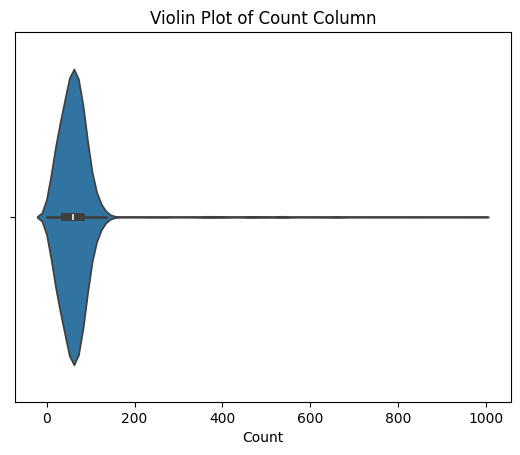

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
sns.violinplot(x=df['count'], )

# Add title and labels
plt.title('Violin Plot of Count Column')
plt.xlabel('Count')
plt.show()

### Manual analysis

In [ ]:
df_manual_analysis = pd.DataFrame({'number': df_depends_on['Target'].unique().tolist() + df_needed_by['Source'].unique().tolist()})
df_manual_analysis.drop_duplicates(subset='number', inplace=True)
df_manual_analysis = df_manual_analysis.sample(n=379)
df_manual_analysis.sort_values('number', inplace=True)
df_manual_analysis.reset_index(drop=True, inplace=True)

df_manual_analysis = pd.merge(
    left=df_manual_analysis, 
    right=df_depends_on.drop_duplicates(subset='Target')[['Target', 'worked_revisions']], 
    left_on='number',
    right_on='Target',
    how='left',
    suffixes=('_target', '_source')
)
df_manual_analysis.loc[df_manual_analysis['worked_revisions'].isnull(), 'worked_revisions'] = df_manual_analysis.loc[df_manual_analysis['worked_revisions'].isnull(), 'number'].map(lambda x: df_needed_by.loc[df_needed_by['Source']==x, 'worked_revisions'].values[0])
labels = {
    1: "Configuration",
    2: "Dependency",
    3: "Code enhancement",
    4: "New features",
    5: "Docs",
    6: "Renaming",
    7: "Tests",
    8: "Refactoring",
    9: "Moving resources",
    10: "Others",
}
nbr = 920233
df_manual_analysis.loc[
    df_manual_analysis['number']==nbr,
    ["reviewer_suggest", "reason", 'comment']
] = [0, labels[2], ""]
df_manual_analysis.to_csv(osp.join(".", "Files", "manual_analysis.csv"), index=None)

In [55]:
df_manual_analysis = pd.read_csv(osp.join(".", "Files", "manual_analysis.csv"))

In [428]:
df_manual_analysis

,number,worked_revisions,reason,comment,reviewer_suggest,tag
0,156691,1.0,Refactoring,NaN,0.0,NaN
1,161355,1.0,Code enhancement,NaN,0.0,NaN
2,175394,1.0,Code enhancement,NaN,0.0,NaN
3,181260,1.0,Tests,NaN,0.0,NaN
4,182072,1.0,Configuration,NaN,0.0,NaN
...,...,...,...,...,...,...
374,918920,1.0,Tests,NaN,0.0,NaN
375,919265,1.0,Tests,NaN,0.0,NaN
376,919339,1.0,Tests,NaN,0.0,NaN
377,919494,1.0,Tests,NaN,0.0,NaN


In [ ]:
df_manual_analysis = pd.read_csv(osp.join(".", "Files", "manual_analysis.csv"))
df_manual_analysis.loc[df_manual_analysis['reason']=='Test', 'reason'] = 'Tests'
df_manual_analysis['reason'] = df_manual_analysis['reason'].map(lambda x: x.split(','))
df_manual_analysis = df_manual_analysis.explode(column='reason')
# Calculate the percentage of missing dependencies
# df_manual_analysis = df_manual_analysis.groupby('reason').apply(lambda x: pd.Series({
#     '\# missing deps': (x['worked_revisions'] > 1).sum(),
#     'Total': x['worked_revisions'].count(),
#     '\\% of missing': f"{round((x['worked_revisions'] > 1).sum() / len(x) * 100, 2)}\%"
#     # 'Description': 'No description yet'
# })).reset_index()

# # # Rename columns to match the desired output
# df_manual_analysis.rename(columns={'reason': 'Category'}, inplace=True)
# df_manual_analysis.sort_values(by='\# missing deps', ascending=0, inplace=True)

In [310]:
tags = {
    1: 'Complex change',
    2: 'Project unfamiliarity',
    3: 'Inconsistent deps',
    4: 'Build failure'
}

In [186]:
print(df_manual_analysis.to_latex(index=False, caption='A detailed overview of various reasons for which developers miss adding a dependency.', label='tab:manual-analysis', float_format="%.2f", ))

\begin{table}
\caption{A detailed overview of various reasons for which developers miss adding a dependency.}
\label{tab:manual-analysis}
\begin{tabular}{lrrl}
\toprule
Category & \# missing deps & Total & \% of missing \\
\midrule
Configuration & 43 & 110 & 39.09\% \\
Dependency & 28 & 55 & 50.91\% \\
Refactoring & 26 & 60 & 43.33\% \\
New features & 25 & 48 & 52.08\% \\
Tests & 23 & 52 & 44.23\% \\
Code enhancement & 14 & 26 & 53.85\% \\
Docs & 8 & 13 & 61.54\% \\
Moving resources & 3 & 11 & 27.27\% \\
Renaming & 2 & 11 & 18.18\% \\
Duplicate & 0 & 1 & 0.0\% \\
\bottomrule
\end{tabular}
\end{table}



### Calculating Cohen's Kappa

In [69]:
df_man_jamel = pd.read_excel("./Files/Jamel.xlsx")
df_man_jamel = df_man_jamel.iloc[:50, [0, 2, 5]]
df_man_jamel.rename(columns={'reason': 'Rater1', 'Jamel category': 'Rater2'}, inplace=True)
df_man_med = pd.read_csv("./Files/mohammed.csv")
df_man_med = df_man_med.iloc[:50, [0, 2, 5]]
df_man_med.rename(columns={'reason': 'Rater1', 'mohammed_category': 'Rater2'}, inplace=True)

df_man_combined = pd.concat((df_man_med, df_man_jamel))

In [78]:
from sklearn.metrics import cohen_kappa_score

# Example data: two raters' categorical ratings (same length)
rater1 = df_man_combined['Rater1']
rater2 = df_man_combined['Rater2']

kappa = cohen_kappa_score(rater1, rater2)
print(f"Cohen's kappa: {kappa:.3f}")

# Interpretation
if kappa < 0:
    print("No agreement")
elif 0 <= kappa <= 0.20:
    print("Slight agreement")
elif 0.20 < kappa <= 0.40:
    print("Fair agreement")
elif 0.40 < kappa <= 0.60:
    print("Moderate agreement")
elif 0.60 < kappa <= 0.80:
    print("Substantial agreement")
elif kappa > 0.80:
    print("Almost perfect agreement")

Cohen's kappa: 0.644
Substantial agreement
